In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('train.csv')
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')

In [3]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [5]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
train['Date'] = pd.to_datetime(train['Date'])
features['Date'] = pd.to_datetime(features['Date'])

In [7]:
feature_store = pd.merge(features, stores, on='Store', how='inner')

df = pd.merge(train, features.drop(columns=['IsHoliday']), on=['Store', 'Date'], how='left')

print(f"Columns in merged df: {df.columns.tolist()}")

Columns in merged df: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']


In [8]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [9]:
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
missing = [col for col in markdown_cols if col not in df.columns]

if not missing:
    df[markdown_cols] = df[markdown_cols].fillna(0)
    print("Success! All Markdown columns found and cleaned.")
else:
    print(f"Still missing: {missing}")
    print("Current columns in df are:", df.columns.tolist())

Success! All Markdown columns found and cleaned.


In [10]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106


In [11]:
# Was there ANY promotion?
df['Is_Promoted'] = (df[markdown_cols].sum(axis=1) > 0).astype(int)

# Creating a 'Total_Markdown' feature
df['Total_Markdown'] = df[markdown_cols].sum(axis=1)

In [12]:
df['Date'] = pd.to_datetime(df['Date'])

In [13]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Day'] = df['Date'].dt.day_name()
df['Is Month End'] = df['Date'].dt.is_month_end
df['Week'] = df['Date'].dt.isocalendar().week

In [14]:
# Sort data to ensure chronological order within each Dept
df = df.sort_values(['Store', 'Dept', 'Date'])

# Create the lag: "Shift" the sales forward by 52 weeks
# We group by Store and Dept so we don't accidentally pull sales from a different store
df['Sales_Last_Year'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(52)

# Handle the first year of data
# Since the first 52 weeks won't have a "last year," we fill them with the median
# This prevents the model from seeing NaNs
df['Sales_Last_Year'] = df['Sales_Last_Year'].fillna(df['Weekly_Sales'].median())

In [15]:
monthly_sales = df.groupby('Month')['Sales_Last_Year'].sum().reset_index()

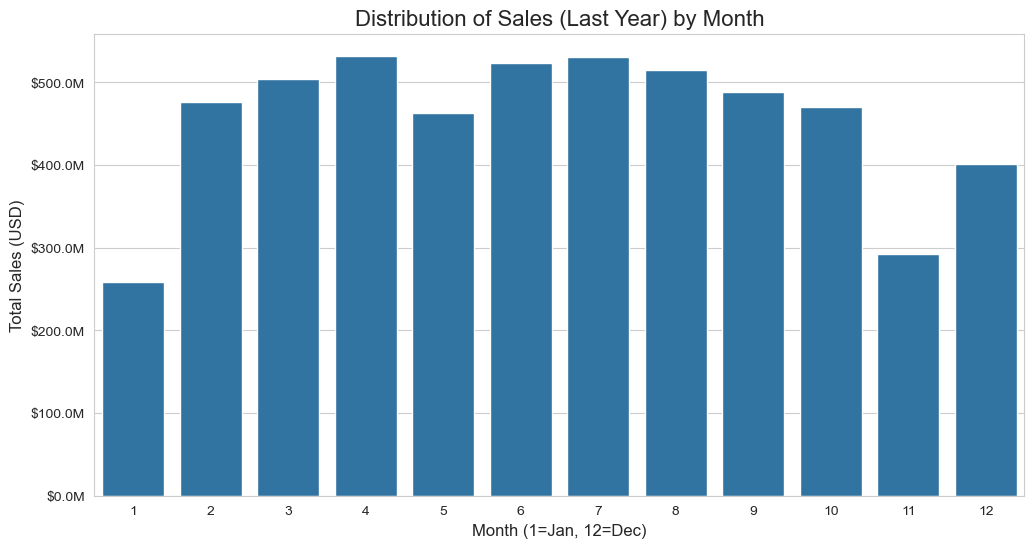

In [34]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

plot = sns.barplot(
    data=monthly_sales, 
    x='Month', 
    y='Sales_Last_Year'
)


plt.title('Distribution of Sales (Last Year) by Month', fontsize=16)
plt.xlabel('Month (1=Jan, 12=Dec)', fontsize=12)
plt.ylabel('Total Sales (USD)', fontsize=12)


from matplotlib.ticker import FuncFormatter
plot.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x*1e-6:.1f}M'))

plt.show()

In [17]:
#Function to find the Christmas date for any given year
def get_christmas(date):
    return pd.Timestamp(year=date.year, month=12, day=25)

# Calculate the difference
# We use .apply() to find Christmas for that specific year, then subtract
df['Christmas_Date'] = df['Date'].apply(get_christmas)
df['Days_Until_Christmas'] = (df['Christmas_Date'] - df['Date']).dt.days

# Cleanup: If the date is after Dec 25th, it might show negative or 360+ days.
# We reset any negative values (post-Christmas sales) to 0 or leave as is to show "days since".
df.loc[df['Days_Until_Christmas'] < 0, 'Days_Until_Christmas'] = 0

In [18]:
# Create a flag for the 3 weeks (21 days) leading up to Christmas
df['Is_Pre_Holiday'] = df['Days_Until_Christmas'].apply(lambda x: 1 if 0 < x <= 21 else 0)

In [19]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Total_Markdown,Month,Year,Day,Is Month End,Week,Sales_Last_Year,Christmas_Date,Days_Until_Christmas,Is_Pre_Holiday
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,...,0.0,2,2010,Friday,False,5,7612.03,2010-12-25,323,0
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,...,0.0,2,2010,Friday,False,6,7612.03,2010-12-25,316,0
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,...,0.0,2,2010,Friday,False,7,7612.03,2010-12-25,309,0
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,...,0.0,2,2010,Friday,False,8,7612.03,2010-12-25,302,0
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,...,0.0,3,2010,Friday,False,9,7612.03,2010-12-25,295,0


In [20]:
# Sort by date to ensure the split is chronological
df = df.sort_values('Date')

# Define the features (X) and the target (y)
features = [
    'Store', 'Dept', 'IsHoliday', 'Month', 'Week', 'Is Month End', 
    'Days_Until_Christmas', 'Is_Pre_Holiday', 'Fuel_Price','Sales_Last_Year', 
    'CPI', 'Unemployment', 'MarkDown1', 'MarkDown2', 
    'MarkDown3', 'MarkDown4', 'MarkDown5'
]

X = df[features]
y = df['Weekly_Sales']

# Manual Split (e.g., Use 80% for training, 20% for testing)
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"Training from {df.iloc[0]['Date']} to {df.iloc[split_index]['Date']}")
print(f"Testing from {df.iloc[split_index+1]['Date']} to {df.iloc[-1]['Date']}")

Training from 2010-02-05 00:00:00 to 2012-04-13 00:00:00
Testing from 2012-04-13 00:00:00 to 2012-10-26 00:00:00


In [21]:
from xgboost import XGBRegressor

In [22]:
xgb_model = XGBRegressor(
    n_estimators = 500,
    learning_rate = 0.1,
    max_depth = 6,
    subsample = 0.8,
    colsample_bytree = 0.8,
    n_jobs = -1,
    random_state = 42
)

xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [23]:
pred = xgb_model.predict(X_test)

In [24]:
from sklearn.metrics import mean_absolute_error

print('Mean Absolute Error: ', mean_absolute_error(y_test, pred))

Mean Absolute Error:  2085.439604169281


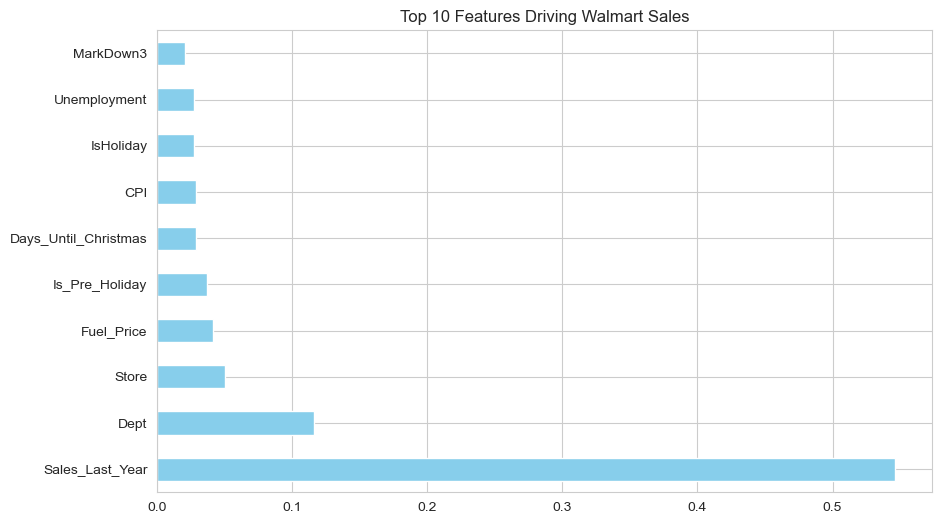

In [25]:
# Plotting Feature Importance
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(xgb_model.feature_importances_, index=features)
feat_importances.nlargest(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 Features Driving Walmart Sales')
plt.show()

In [26]:
def calculate_wmae(y_true, y_pred, is_holiday):
    # Weights: 5 for holidays, 1 for regular weeks
    weights = is_holiday.apply(lambda x: 5 if x else 1)
    
    # Calculate Weighted Absolute Error
    weighted_error = weights * np.abs(y_true - y_pred)
    
    # Return the mean
    return np.sum(weighted_error) / np.sum(weights)

# Example usage after you make predictions:
# error = calculate_wmae(y_test, predictions, X_test['IsHoliday'])
# print(f"Your Model WMAE: {error:.2f}")

In [27]:
from sklearn.model_selection import TimeSeriesSplit

#Initialize the TimeSeriesSplit (5 folds is standard)
tscv = TimeSeriesSplit(n_splits=5)

#Storage for our error scores
wmae_scores = []

print("Starting Time Series Cross-Validation...\n")

#The Loop
# 'train_index' and 'test_index' are the row numbers for each fold
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    
    # Split the data
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model_cv = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, n_jobs=-1)
    model_cv.fit(X_train_cv, y_train_cv)
    
    # Predict
    preds = model_cv.predict(X_test_cv)
    
    # Calculate WMAE for this fold
    # (Using the IsHoliday column from the test set for weighting)
    fold_wmae = calculate_wmae(y_test_cv, preds, X_test_cv['IsHoliday'])
    wmae_scores.append(fold_wmae)
    
    print(f"Fold {i+1} WMAE: ${fold_wmae:.2f}")

print(f"\nAverage Cross-Validation WMAE: ${np.mean(wmae_scores):.2f}")

Starting Time Series Cross-Validation...

Fold 1 WMAE: $6652.19
Fold 2 WMAE: $5986.13
Fold 3 WMAE: $3094.53
Fold 4 WMAE: $3517.50
Fold 5 WMAE: $2060.01

Average Cross-Validation WMAE: $4262.07


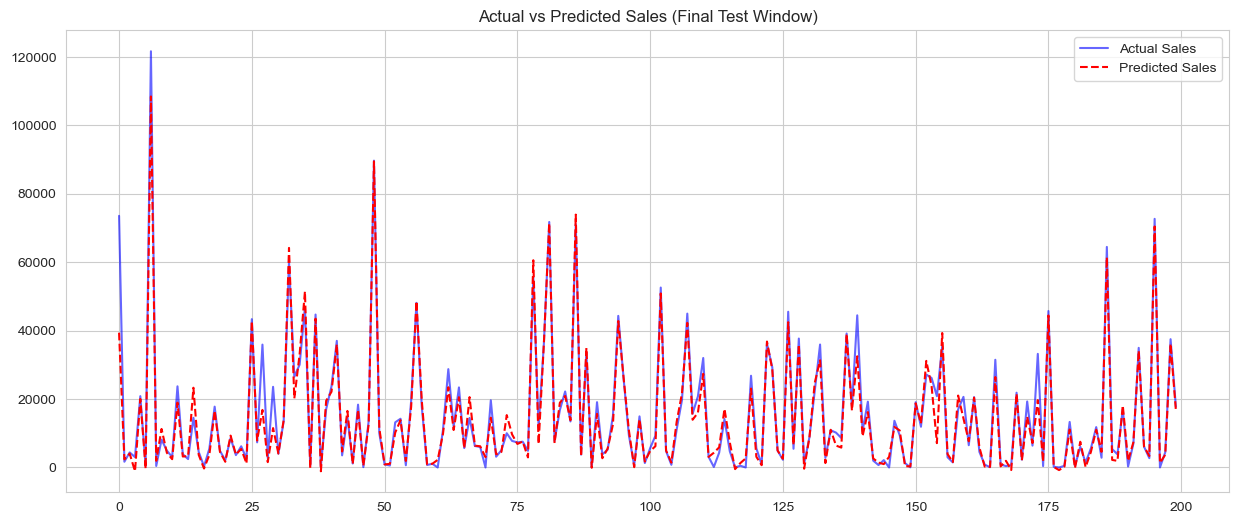

In [28]:
plt.figure(figsize=(15, 6))
plt.plot(y_test_cv.values[:200], label='Actual Sales', color='blue', alpha=0.6)
plt.plot(preds[:200], label='Predicted Sales', color='red', linestyle='--')
plt.title('Actual vs Predicted Sales (Final Test Window)')
plt.legend()
plt.show()

In [30]:
# Load the official test data
test_raw = pd.read_csv('test.csv')
test_raw['Date'] = pd.to_datetime(test_raw['Date'])

# Get the last known sales for each Store/Dept to use as the lag for the Test set
last_year_sales = df[['Store', 'Dept', 'Date', 'Weekly_Sales']].copy()
last_year_sales['Date'] = last_year_sales['Date'] + pd.DateOffset(weeks=52)
last_year_sales.rename(columns={'Weekly_Sales': 'Sales_Last_Year'}, inplace=True)

test_df = pd.merge(test_raw, feature_store, on=['Store', 'Date', 'IsHoliday'], how='left')
test_df = pd.merge(test_df, last_year_sales, on=['Store', 'Dept', 'Date'], how='left')
test_df['Sales_Last_Year'] = test_df['Sales_Last_Year'].fillna(df['Weekly_Sales'].median())

# Apply Feature Engineering
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df['Month'] = test_df['Date'].dt.month
test_df['Year'] = test_df['Date'].dt.year
test_df['Week'] = test_df['Date'].dt.isocalendar().week

# Christmas Logic
test_df['Christmas_Date'] = test_df['Date'].apply(lambda x: pd.Timestamp(year=x.year, month=12, day=25))
test_df['Days_Until_Christmas'] = (test_df['Christmas_Date'] - test_df['Date']).dt.days
test_df.loc[test_df['Days_Until_Christmas'] < 0, 'Days_Until_Christmas'] = 0
test_df['Is Month End'] = test_df['Date'].dt.is_month_end
test_df['Is_Pre_Holiday'] = test_df['Days_Until_Christmas'].apply(lambda x: 1 if 0 < x <= 21 else 0)

# Fill Markdowns
test_df[markdown_cols] = test_df[markdown_cols].fillna(0)

# 4. Select only the features the model was trained on
X_official_test = test_df[features]

In [31]:
# Generate predictions
test_predictions = xgb_model.predict(X_official_test)

# Add predictions back to the dataframe for easy viewing
test_df['Predicted_Sales'] = test_predictions

# Look at the first few rows
print(test_df[['Store', 'Dept', 'Date', 'Predicted_Sales']].head())

   Store  Dept       Date  Predicted_Sales
0      1     1 2012-11-02     46632.226562
1      1     1 2012-11-09     18781.109375
2      1     1 2012-11-16     19517.587891
3      1     1 2012-11-23     20058.863281
4      1     1 2012-11-30     17654.585938


In [32]:
# Check for negative predictions
neg_count = (test_df['Predicted_Sales'] < 0).sum()
if neg_count > 0:
    print(f"Warning: {neg_count} negative predictions found. Clipping to 0.")
    test_df.loc[test_df['Predicted_Sales'] < 0, 'Predicted_Sales'] = 0

In [33]:
# Create the ID column: Store_Dept_Date
test_df['Id'] = test_df['Store'].astype(str) + '_' + \
                test_df['Dept'].astype(str) + '_' + \
                test_df['Date'].dt.strftime('%Y-%m-%d')

# Create final submission dataframe
submission = test_df[['Id', 'Predicted_Sales']]
submission.columns = ['Id', 'Weekly_Sales']

# Save to CSV
submission.to_csv('walmart_submission.csv', index=False)
print("Submission file saved!")

Submission file saved!
